In [54]:
import zipfile
import urllib.request
import os.path

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import logit, expit
import pandas as pd
import seaborn as sns
red, blue, green = sns.color_palette('Set1', 3)
sns.set_style('ticks')
sns.set_context('talk')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.metrics import roc_curve

Data obtained from [dolthub](https://www.dolthub.com/repositories/Liquidata/corona-virus/doc/master/README.md).

> There is a `case_details` table that has individual cases with additional information like sex and age from Singapore, Hong Kong, and South Korea. It has over 7500 individual patient entries.

The following cells load the data for places and cases and merge the two tables.

In [55]:
places = pd.read_csv('../../../Research/COVID-19/corona-virus/places.csv', index_col='place_id')    
places.head()

,province_state,country_region,latitude,longitude
place_id,,,,
1,Hubei,China,30.9756,112.2707
2,Guangdong,China,23.3417,113.4244
3,Henan,China,33.8820,113.6140
4,Hunan,China,27.6104,111.7088
5,Jiangxi,China,27.6140,115.7221


In [56]:
cases = pd.read_csv('../../../Research/COVID-19/corona-virus/case_details.csv')#, index_col='case_id')    
print(cases.shape)
cases.head()

(5038, 11)


,source,case_id,case_name,age,sex,nationality,current_status,symptomatic_date,confirmed_date,recovered_date,place_id
0,https://coronavirus-ph-api.now.sh/cases,1,NaN,38.0,F,Chinese,Recovered,NaN,2020-01-30 00:00:00,NaN,48
1,https://coronavirus-ph-api.now.sh/cases,2,NaN,44.0,M,Chinese,Died,NaN,2020-02-02 00:00:00,NaN,48
2,https://coronavirus-ph-api.now.sh/cases,3,NaN,60.0,F,Chinese,Recovered,NaN,2020-02-05 00:00:00,NaN,48
3,https://coronavirus-ph-api.now.sh/cases,4,NaN,48.0,M,Filipino,Recovered,NaN,2020-03-05 00:00:00,NaN,48
4,https://coronavirus-ph-api.now.sh/cases,5,NaN,62.0,M,Filipino,Died,NaN,2020-03-05 00:00:00,NaN,48


In [57]:
df = pd.merge(cases, places, on='place_id')

Next we convert the places names from a categorical (text) variable to four dummy varaibles that take values 0 or 1. We do this because logistic regression takes numeric values. By having one "boolean" variable per country, we will be able to estimat the effect of each place on probability to die from COVID-19.

In [58]:
dummies = pd.get_dummies(df['country_region'])
dummies = dummies.rename(columns={'China':'Hong Kong', 'Korea, South':'South Korea'})
countries = dummies.columns
dummies.head()

,Hong Kong,South Korea,Philippines,Singapore
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


In [6]:
df = pd.concat((df, dummies), axis=1)

There are multiple rows for some cases, so we take the last row for each case. Also, the case identifiers are unique _per country_.

In [59]:
df = df.groupby(['place_id', 'case_id']).last()
df = df.reset_index()

We filter in only cases that ended with recovery or death, the rest of the cases are undertermined yet.

We then create a boolean column for death.

In [8]:
dead = df['current_status'].isin(['deceased', 'Died', 'Dead', 'deceased', 'Desceased'])
released = df['current_status'].isin(['Released', 'released', 'Recovered'])
df = df[dead | released]
df['dead'] = dead.astype(int)

We convert sex to an integer, and extract only the variables of interest.

In [9]:
df['sex'] = df['sex'] == 'F' # convert to boolean
df['sex'] = df['sex'].astype(int) # then convert to int

var_names = ['dead', 'sex', 'age'] + countries.tolist()
df = df[var_names].copy() # what if I don't put .copy?
df = df.dropna() # remove rows with "not a number" elements
df.head()

,dead,sex,age,Hong Kong,South Korea,Philippines,Singapore
1,0,0,66.0,0,0,0,1
2,0,1,53.0,0,0,0,1
3,0,0,37.0,0,0,0,1
4,0,0,36.0,0,0,0,1
5,0,1,56.0,0,0,0,1


We extract the fetures to `X` and the target to `Y`.

In [10]:
X = df[var_names[1:]].values
Y = df[var_names[0]].values

We can plot the distrubtion of cases.

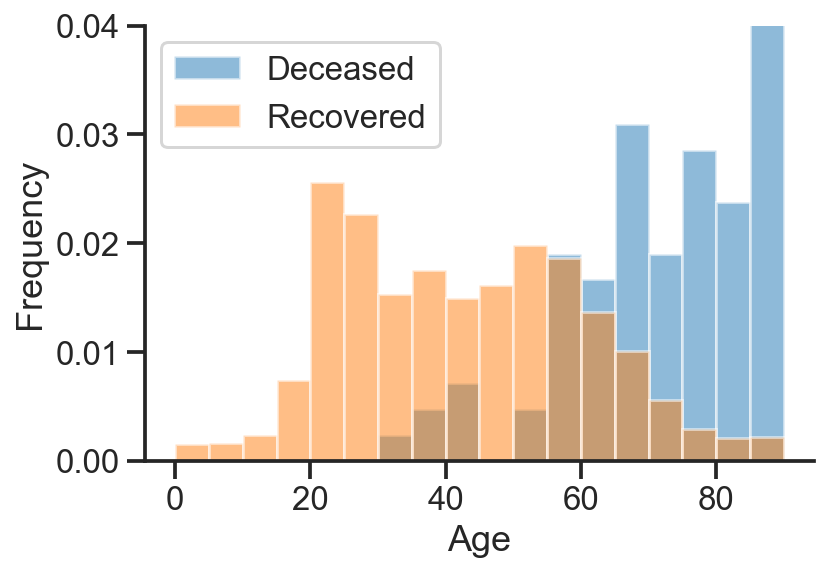

In [11]:
kws = dict(density=True, alpha=0.5, bins=np.arange(0, df['age'].max(), 5)) # declare keyword arguments once as a dict

plt.hist(df.loc[df['dead']==1, 'age'], label='Deceased', **kws) # ** unpacks the kws dict 
plt.hist(df.loc[df['dead']==0, 'age'], label='Recovered', **kws)
plt.legend() # labels set in the hist call
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.ylim(0, 0.04)
sns.despine()

Now we fit a logistic model to the data.

In [60]:
model = LogisticRegression(penalty='none', fit_intercept=True)
model.fit(X, Y)

Here are the effects of the features, using the model coefficients.

In [60]:
for var, coef in zip(var_names[1:], np.exp(model.coef_).ravel()):
    print(var, '\t', coef)
print('intercept\t', np.exp(model.intercept_)[0])

sex 	 0.2340559646323335
age 	 1.1122296004595857
Hong Kong 	 7.577153174380587e-06
South Korea 	 45.90402925662413
Philippines 	 697.9921182807653
Singapore 	 1.3678560892510736e-05
intercept	 3.320838849905383e-06


We see that sex had a strong effect, with females less likely to die, each year of age increases the risk of death, and that Philippines are of the greatest risk.

Lets look at the historgram of probability to die for deceased (blue) and recovered (red) to find a good threshold. 

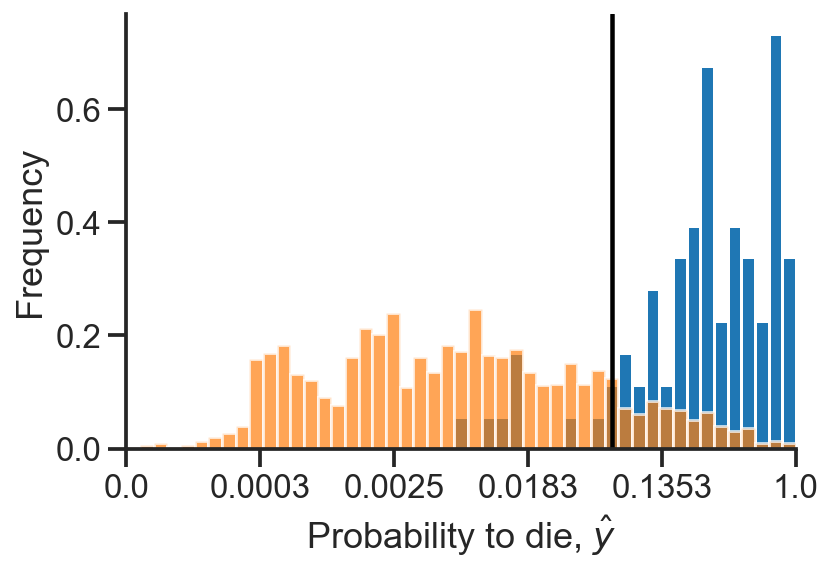

In [49]:
logYhat = model.predict_log_proba(X)[:,1]

bins = np.linspace(-10, 0, 50)
plt.hist(logYhat[Y==1], bins=bins,density=True, label='Deceased')
plt.hist(logYhat[Y==0], bins=bins,density=True, alpha=0.7, label='Recovered');
plt.xlabel(r'Probability to die, $\hat{y}$')
plt.ylabel('Frequency')
xticks = plt.xticks()[0]
plt.xticks(xticks, np.round(np.exp(xticks), 4))
plt.xlim(bins.min(), bins.max())
plt.axvline(-2.75, color='k')
sns.despine()

Indeed if we look at the ROC curve, the threshold we chose isright on the "knee" of the curve.

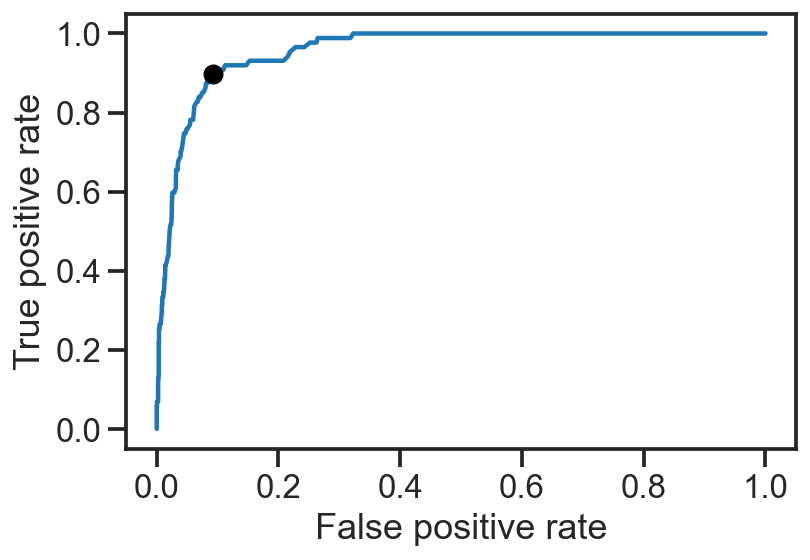

In [45]:
fpr, tpr, thresholds = roc_curve(Y, np.exp(logYhat))
plt.plot(fpr, tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
idx = (np.log(thresholds) < -2.75).argmax()
plt.plot(fpr[idx], tpr[idx], 'ok');

We plot the probability to die for each age in each countries, separated by sex.

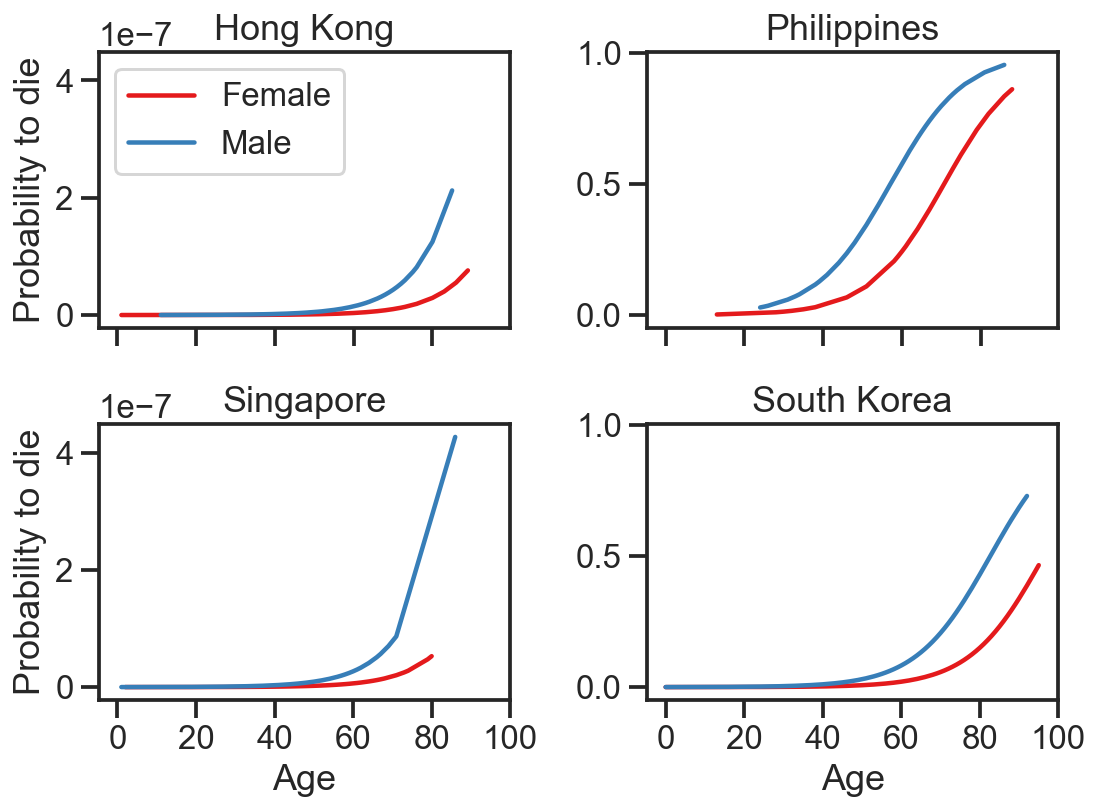

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey='col')
for country, ax in zip(sorted(countries), axes.flat):
    df_ = df[df[country]==1]
    df_ = df_.sort_values('age')
    X_ = df_[var_names[1:]]
    Y_ = df_[var_names[0]]
    Yhat_ = model.predict_proba(X_)[:,1]
    female = df_['sex'] == 1
    ax.plot(X_.loc[female, 'age'], Yhat_[female], '-', color=red, label='Female')
    ax.plot(X_.loc[~female, 'age'], Yhat_[~female], '-', color=blue, label='Male')
    ax.set(title=country)
axes[0,0].legend(loc='upper left')
axes[0,0].set(ylabel='Probability to die')
axes[1,0].set(xlabel='Age', ylabel='Probability to die', xticks=[0, 20, 40, 60, 80, 100])
axes[1,1].set(xlabel='Age', xticks=[0, 20, 40, 60, 80, 100])
fig.tight_layout()

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Scientific Computing with Python_](https://scicompy.yoavram.com/) course at IDC Herzliya.

The notebook was written using [Python](http://python.org/) 3.6.5.
Dependencies listed in [environment.yml](../environment.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)